In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils as torchU
!pip install pytorch_lightning
!pip install --upgrade pytorch_lightning==0.7.6
import pytorch_lightning as torch_light
import numpy as np
import matplotlib.pyplot as plt 

     |████████████████████████████████| 307kB 2.2MB/s 
     |████████████████████████████████| 276kB 5.3MB/s 
     |████████████████████████████████| 829kB 7.4MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=b01c3ff6e3565a1152d85316b7bff865c5e9ff5644f96d89cca2e9e946521784
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=810f2a026f788226c8f8aa1b337ca02d816c7bac29d07e366e680db7332657b6
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
     |██████████████████████████████

In [2]:
torch_light.seed_everything()

No correct seed found, seed set to 1076084420


1076084420

In [4]:
def check_validate(set,num_classes):
  result = torch.zeros(num_classes)
  for ele in set:
    batch,truth = ele
    result[truth] +=1
  print("class distribution in validation set")
  print(result)


In [5]:
"""
  Our model is implemented in a way that it is very flexible w.r.t to network architecture
  and easy to expand any functionality
"""

class Model(torch_light.LightningModule):
    def __init__(self,layers,layer_type,batch_size,learning_rate,optim,loss_func):
        super(Model, self).__init__()
        self.hparams={}
        self.hparams["optimizer"]=optim
        self.hparams["learning_rate"]=learning_rate
        self.hparams["batch_size"]=batch_size
        self.hparams["layers"]=layers
        self.hparams["layer_type"]=layer_type
        self.hparams["loss_func"]=loss_func
        self.hparams["image_dim"]=[]
        self.hparams["image"]=[]
      
        self.net1d = []
        self.net2d = []
        for ind in range(len(self.hparams["layer_type"])):
          if self.hparams["layer_type"][ind] == "batchnorm":
            dim = self.hparams["layers"][ind][0]
            if dim == 1:
              self.net1d.append(nn.BatchNorm1d(self.hparams["layers"][ind][1]))
            elif dim == 2:
              self.net2d.append(nn.BatchNorm2d(self.hparams["layers"][ind][1]))
          if self.hparams["layer_type"][ind] == "maxpool":
            self.net2d.append(nn.MaxPool2d(self.hparams["layers"][ind][0],self.hparams["layers"][ind][1],self.hparams["layers"][ind][2]))
            self.hparams["image_dim"].append(2)
            continue
          if self.hparams["layer_type"][ind] == "avgpool":
            self.net2d.append(nn.AvgPool2d(self.hparams["layers"][ind][0],self.hparams["layers"][ind][1],self.hparams["layers"][ind][2]))
            self.hparams["image_dim"].append(2)
            continue
          if self.hparams["layer_type"][ind] == "cnn":
            self.net2d.append(nn.Conv2d(in_channels=self.hparams["layers"][ind][0],out_channels=self.hparams["layers"][ind][1],
                                        kernel_size=self.hparams["layers"][ind][2],stride=self.hparams["layers"][ind][3],padding=self.hparams["layers"][ind][4]))
            self.net2d.append(nn.ReLU())
            self.hparams["image_dim"].append(2)
            continue
          if self.hparams["layer_type"][ind] == "tanh":
            self.net1d.append(nn.Linear(self.hparams["layers"][ind][0],self.hparams["layers"][ind][1]))
            self.net1d.append(nn.Tanh())
            self.hparams["image_dim"].append(1)
            continue
          if self.hparams["layer_type"][ind] == "sigmoid":
            self.net1d.append(nn.Linear(self.hparams["layers"][ind][0],self.hparams["layers"][ind][1]))
            self.net1d.append(nn.Sigmoid())
            self.hparams["image_dim"].append(1)
            continue
          if self.hparams["layer_type"][ind] == "linear":
            self.net1d.append(nn.Linear(self.hparams["layers"][ind][0],self.hparams["layers"][ind][1]))
            self.hparams["image_dim"].append(1)
            continue
          if self.hparams["layer_type"][ind] == "relu":
            self.net1d.append(nn.Linear(self.hparams["layers"][ind][0],self.hparams["layers"][ind][1]))
            self.net1d.append(nn.ReLU())
            self.hparams["image_dim"].append(1)
            continue
          if self.hparams["layer_type"][ind] == "dropout":
            self.net1d.append(nn.Dropout(self.hparams["layers"][ind][0]))
            self.hparams["image_dim"].append(1)
            continue
        self.net2d = nn.Sequential(*self.net2d)
        self.net1d = nn.Sequential(*self.net1d)
        
    def forward(self, x):
      changed = False
      if len(self.net2d) != 0:
        x = self.net2d(x)
        changed = True
      if len(self.net1d) !=0:
        if changed:
          x = x.view(x.size(0),-1)
          changed = False
        x = self.net1d(x)
      return x
    def training_step(self, batch, batch_idx):
      batch, batch_labels = batch
      pred = self.forward(batch)
      loss = self.get_loss_func()
      loss = loss(pred,batch_labels)
      accuracy = torch.sum(torch.max(pred, 1)[1] == batch_labels).float() / len(batch_labels)
      #self.hparams["kernels"].append(get_kernels(self))
      return {'loss': loss, 'train_acc':accuracy} 
    def training_epoch_end(self, outputs):
      avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
      avg_acc = torch.stack([x['train_acc'] for x in outputs]).mean()
      lr = self.trainer.lr_schedulers[0]['scheduler']
      logs = {'loss/train': avg_loss,'accuracy/train':avg_acc,'step':self.current_epoch}
      return {'avg_train_loss': avg_loss, 'log': logs}
    def validation_step(self, batch, batch_idx):
      batch, batch_labels = batch
      pred = self.forward(batch)
      loss = self.get_loss_func()
      loss = loss(pred,batch_labels)
      accuracy = torch.sum(torch.max(pred, 1)[1] == batch_labels).float() / len(batch_labels)
      return {'val_loss': loss,'val_acc':accuracy} 
    def validation_epoch_end(self, outputs):
      avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
      logs = {'loss/val': avg_loss,'accuracy/val':avg_acc,'step':self.current_epoch}
      return {'avg_val_loss': avg_loss, 'log': logs}
    def test_step(self, batch, batch_idx):
      batch, batch_labels = batch
      #take one image to visualize activation 
      tmp = batch[np.random.randint(len(batch))]
      tmp = tmp.cpu()  
      self.hparams["image"].append(tmp)    
      #continue test step 
      pred = self.forward(batch) 
      loss = self.get_loss_func()
      loss = loss(pred,batch_labels)
      accuracy = torch.sum(torch.max(pred, 1)[1] == batch_labels).float() / len(batch_labels)
      return {'test_loss': loss,'test_acc':accuracy}
    def test_epoch_end(self, outputs):
      avg_test_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
      avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
      logs = {'loss/test': avg_test_loss,'accuracy/test':avg_test_acc}
      return {'avg_test_loss': avg_test_loss, 'log':logs}
    def prepare_data(self):
      dataset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
      self.trainset, self.valset = torchU.data.random_split(dataset,[45000,5000]) 
      check_validate(self.valset,10)
      self.testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
    def train_dataloader(self):
      return torchU.data.DataLoader(self.trainset,self.hparams["batch_size"],shuffle=True,num_workers=8)
    def val_dataloader(self):
      return torchU.data.DataLoader(self.valset,len(self.valset),shuffle=False,num_workers=8)
    def test_dataloader(self):
      return torchU.data.DataLoader(self.testset,len(self.testset),shuffle=False,num_workers=8)
    def configure_optimizers(self):
      optimizer=None
      if self.hparams["optimizer"] == 'sgd':
        optimizer = torch.optim.SGD(self.parameters(),lr=self.hparams["learning_rate"], momentum=0.8,nesterov=True)
      elif self.hparams["optimizer"] == 'adam':
        optimizer = torch.optim.Adam(self.parameters(),lr=self.hparams["learning_rate"])
      elif self.hparams["optimizer"] == 'adag':
        optimizer = torch.optim.Adagrad(self.parameters(),lr=self.hparams["learning_rate"])
      elif self.hparams["optimizer"] == 'adad':
        optimizer = torch.optim.Adadelta(self.parameters(),lr=self.hparams["learning_rate"])
      elif self.hparams["optimizer"] == 'rmsp':
        optimizer = torch.optim.RMSprop(self.parameters(),lr=self.hparams["learning_rate"],momentum=0.8)
      lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1,0.999)
      return [optimizer],[lr_scheduler]
    def get_loss_func(self):
      if self.hparams["loss_func"]== "crossentropy":
        return nn.CrossEntropyLoss()

In [6]:
#mount your google drive and go to that directory where the executed file is.
%cd /content/drive/My Drive/Colab Notebooks/Cuda Vision Lab/Assignment4 
!ls

/content/drive/My Drive/Colab Notebooks/Cuda Vision Lab/Assignment4
assignment4_final.ipynb  assignment4_V6.ipynb
Assignment4ResultsLog	 CUDA_Assignment_4.ipynb
assignment4_V0.ipynb	 cudaVisionlab_assignment_4_Akter,Schmidt.ipynb
assignment4_V3.ipynb	 data
assignment4_V4.ipynb	 lightning_logs
assignment4_V5.ipynb


##We have found avgpool(test accuracy 83.3%) is working better than maxpool(test accuracy 80.5%) and concatenation of both(81.21%) in our current setup. For more details see our lightning logs.

In [7]:
"""
 model details:
  optimizer are: sgd adam adag adad rmsp
  loss functions given extra as parameter
  layer types are:  sigmoid: [input_dim,output_dim]
                    linear: [input_dim,output_dim]
                    tanh: [input_dim,output_dim]
                    relu: [input_dim,output_dim]
                    dropout: [dropout_value]
                    cnn: [input_channel,output_channel,kernel_size,stride,padding]
                    max/avgpool: [kernel_size,stride,padding]
                    batchnorm:[version,dim]
  layers is a list of list containing the parameters per each layer
"""
batch_size = 150
layers = [[3,32,5,1,2],     #(32,32,1)->(32,32,32)
          [2,32],
          [32,64,5,1,2],    #(32,32,32)->(32,32,64)
          [2,64],
          [2,2,0],          #(32,32,64)->(16,16,64)
          [64,64,3,1,1],     #(16,16,64)->(16,16,64)
          [2,64],
          [64,64,3,1,1],     #(16,16,64)->(16,16,64)
          [2,64],
          [2,2,0],           #(16,16,64)->(8,8,64)
          [64,128,3,1,1],    #(8,8,64)->(8,8,128)
          [2,128],
          [128,128,3,1,1],   #(8,8,128)->(8,8,128)
          [2,128],
          [2,2,0],           #(8,8,128)->(4,4,128)
          [4*4*128,512],
          [512,10]
          ]
layers_type = ["cnn","batchnorm","cnn","batchnorm","avgpool","cnn","batchnorm","cnn","batchnorm","avgpool","cnn","batchnorm","cnn","batchnorm","avgpool","linear","relu"]
lr = 0.01
epoches=20

net = Model(layers,layers_type,batch_size,lr,optim="sgd",loss_func="crossentropy")
trainer= torch_light.Trainer(max_epochs=epoches,gpus=-1,fast_dev_run=False)
trainer.fit(net)
trainer.test()

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
class distribution in validation set
tensor([481., 495., 498., 489., 487., 515., 516., 510., 499., 510.])
Files already downloaded and verified



   | Name     | Type        | Params
-------------------------------------
0  | net2d    | Sequential  | 349 K 
1  | net2d.0  | Conv2d      | 2 K   
2  | net2d.1  | ReLU        | 0     
3  | net2d.2  | BatchNorm2d | 64    
4  | net2d.3  | Conv2d      | 51 K  
5  | net2d.4  | ReLU        | 0     
6  | net2d.5  | BatchNorm2d | 128   
7  | net2d.6  | AvgPool2d   | 0     
8  | net2d.7  | Conv2d      | 36 K  
9  | net2d.8  | ReLU        | 0     
10 | net2d.9  | BatchNorm2d | 128   
11 | net2d.10 | Conv2d      | 36 K  
12 | net2d.11 | ReLU        | 0     
13 | net2d.12 | BatchNorm2d | 128   
14 | net2d.13 | AvgPool2d   | 0     
15 | net2d.14 | Conv2d      | 73 K  
16 | net2d.15 | ReLU        | 0     
17 | net2d.16 | BatchNorm2d | 256   
18 | net2d.17 | Conv2d      | 147 K 
19 | net2d.18 | ReLU        | 0     
20 | net2d.19 | BatchNorm2d | 256   
21 | net2d.20 | MaxPool2d   | 0     
22 | net1d    | Sequential  | 1 M   
23 | net1d.0  | Linear      | 1 M   
24 | net1d.1  | Linear      | 5 K   

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: The metric you returned None must be a Torch.Tensor instance, checkpoint not saved HINT: what is the value of val_loss in validation_end()?
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'accuracy/test': tensor(0.8081, device='cuda:0'),
 'avg_test_loss': tensor(1.0047, device='cuda:0'),
 'loss/test': tensor(1.0047, device='cuda:0')}
--------------------------------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [8]:
#function for visualing the kernels
def filter_visualization(kernels,x,y):
  kernels = kernels - kernels.min()
  kernels = kernels / kernels.max()
  fig = plt.figure()
  plt.figure(figsize=(y,x))
  for idx, filt  in enumerate(kernels):
      plt.subplot(x,y, idx + 1)
      plt.imshow(filt[0, :, :])
      plt.axis('off')   
  fig.show()

In [9]:
#function for visualizing activation map
def Activation_Map_Plot(tensor,rows,cols):
  tensor=tensor.squeeze()
  fig = plt.figure(figsize=(cols,rows))
  for i in range(rows*cols):
    ax1 = fig.add_subplot(rows,cols,i+1)
    ax1.imshow(tensor[i])
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

In [10]:
# do not call this for very large numbers
# helps with nice looking plot of kernels and activations
def well_distributed_rows_columns(val):
  if np.sqrt(val)%1 ==0:
    return np.sqrt(val),np.sqrt(val)
  c = int(np.sqrt(val))+1
  while val%c!=0:
    c -= 1
  return val/c,c

CONV: Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([32, 3, 5, 5])
CONV: Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([64, 32, 5, 5])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 128, 3, 3])


<Figure size 432x288 with 0 Axes>

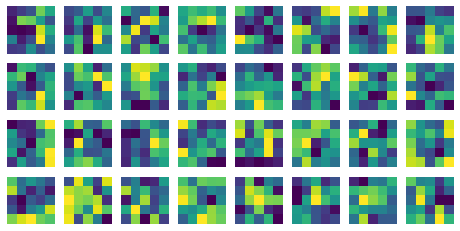

<Figure size 432x288 with 0 Axes>

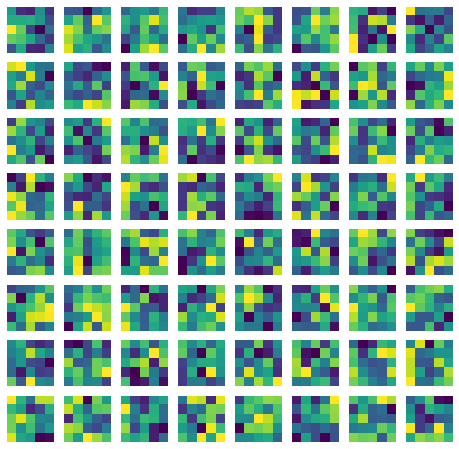

<Figure size 432x288 with 0 Axes>

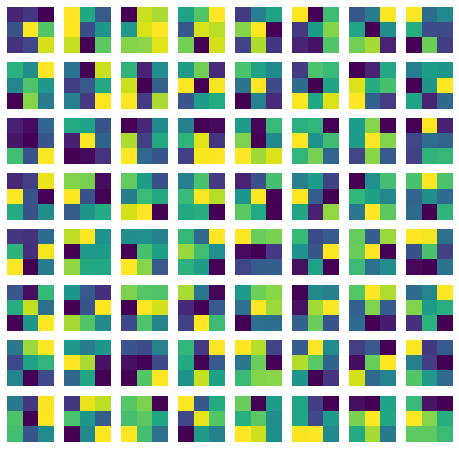

<Figure size 432x288 with 0 Axes>

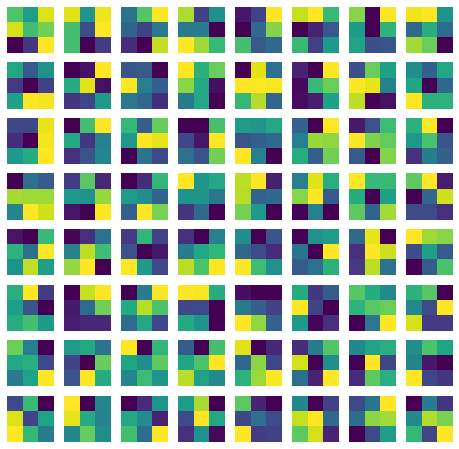

<Figure size 432x288 with 0 Axes>

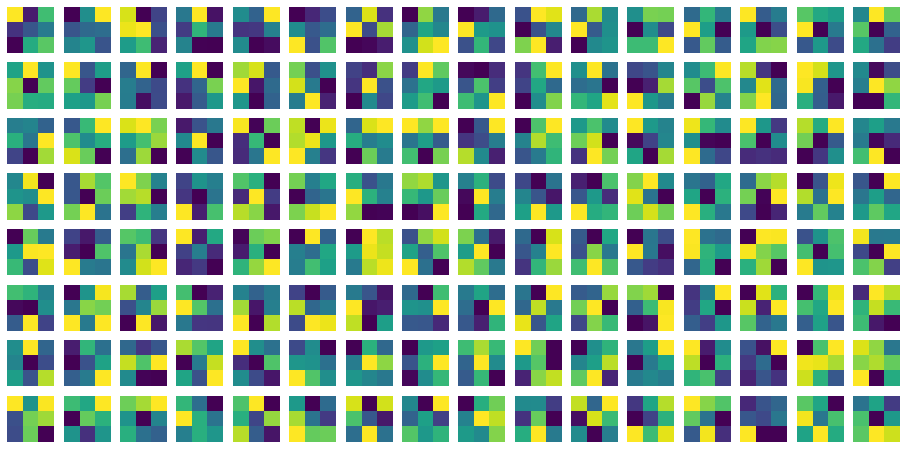

<Figure size 432x288 with 0 Axes>

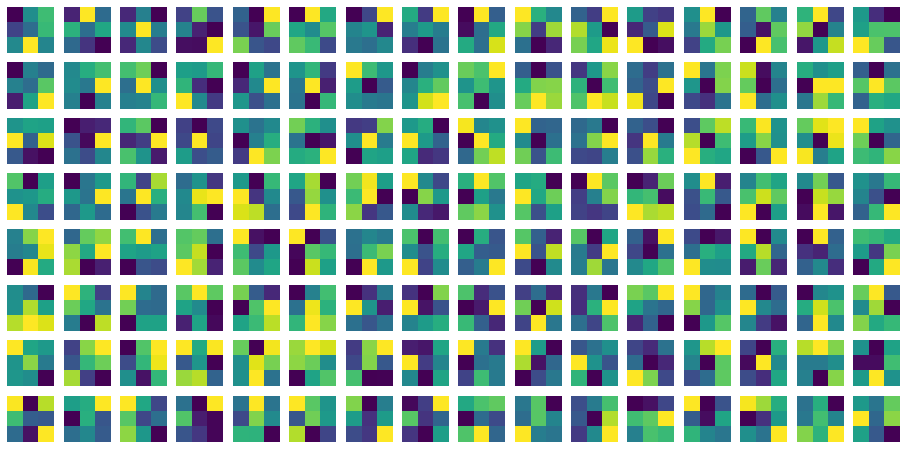

In [11]:
# visualize kernels of each convolutional layer
for layer in list(net.net2d):
  if type(layer)== nn.Conv2d:
    filters = list(layer.parameters())[0]
    print(f"CONV: {layer} ====> SHAPE: {filters.shape}")
    columns,rows = well_distributed_rows_columns(layer.out_channels)
    filter_visualization(filters.cpu().detach().numpy(),rows,columns)


Activation map of Conv layer 1


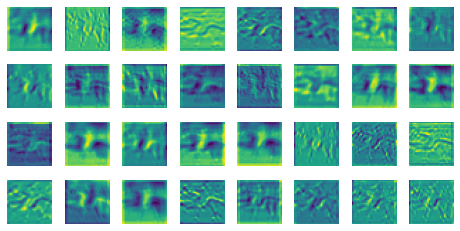

Activation map of Conv layer 2


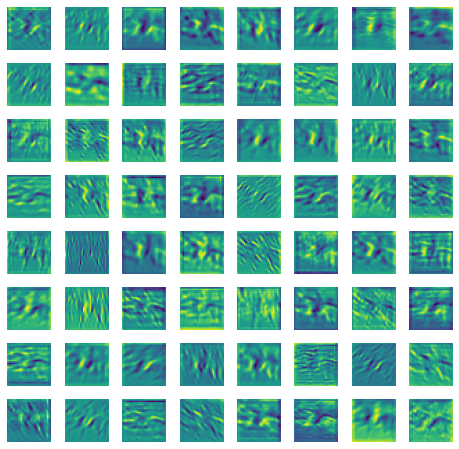

Activation map of Conv layer 3


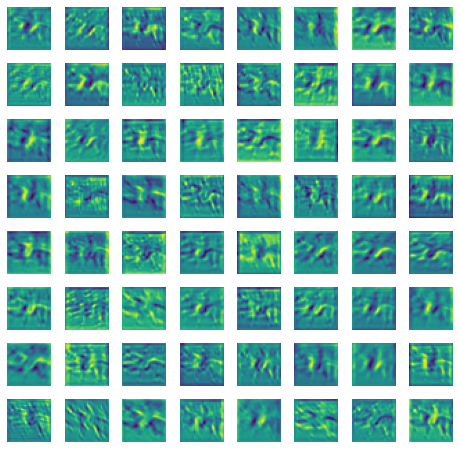

Activation map of Conv layer 4


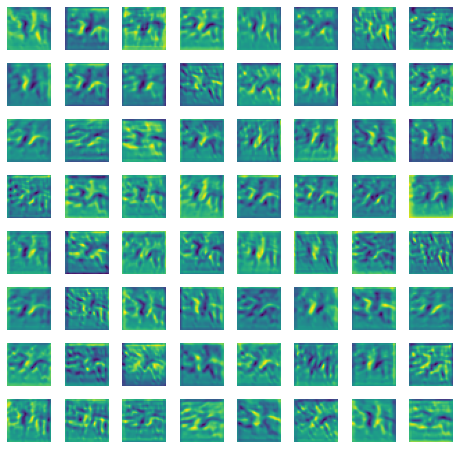

Activation map of Conv layer 5


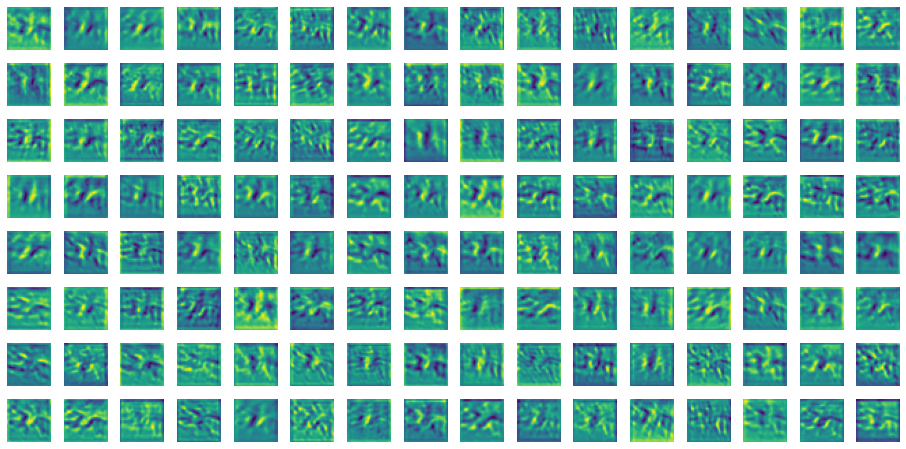

Activation map of Conv layer 6


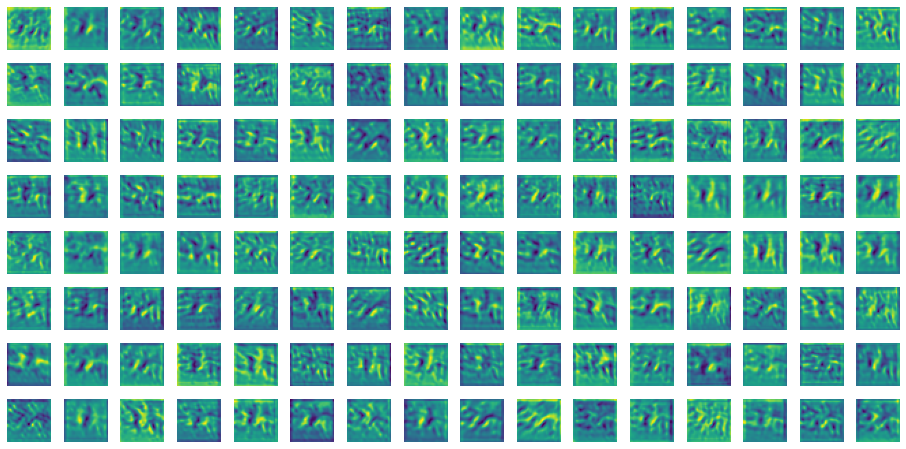

In [12]:
#Activation maps of all CNN layers
from torch.autograd import Variable
test_image = net.hparams["image"]
counter = 0
image = test_image[0].view(1, 3, 32, 32).cuda()
for layer in list(net.net2d):
    if type(layer) == nn.Conv2d:
      counter +=1
      image = layer(image)
      print('Activation map of Conv layer {}'.format(counter))
      columns,rows = well_distributed_rows_columns(layer.out_channels)
      Activation_Map_Plot(image.data.cpu().numpy(),int(rows),int(columns))

In [13]:
def create_correct_mat(input_dim,stride,current_channel_out,output_dim,kernel):
  tmp = torch.zeros((input_dim,input_dim))
  k_size = kernel.shape[0]
  input_dim = input_dim- k_size+stride
  # insert kernel at correct place 
  # compute left top point
  row = stride*int(current_channel_out)
  column = row%input_dim
  #print(current_channel_out)
  row = (row//input_dim)*stride
  row = int(row)
  column = int(column)
  #print(row,column)
  #print(tmp[row:row+k_size,column:column+k_size].shape)
  tmp[row:row+k_size,column:column+k_size] = kernel
  return tmp


In [14]:
def conv2d_to_linear(layer):
  # setting up our parameters for fast access
  channel_out = layer.out_channels
  channel_in = layer.in_channels
  k_size = layer.kernel_size[0]
  stride = layer.stride[0]
  padding = layer.padding[0]
  input_dim = 32+2*padding
  output_dim = int((input_dim-k_size+stride)/stride)
  parameters = list(layer.parameters())[0]

  """"
    The idea is that our input and output is given in following format:
    input: channel_1 ... channel_c1
    output: channel_1 ... channel_c2
    channel_i: row_1 ... row_n  where n is the respecting dimension of the input/output image
    Since FC layer have weights of form: output_dim x input_dim
    I create each row of the weights by iterating over the corresponding channels and 
    create a appropiate zero matrix, insert the kernel, flatten this and do this for all input_channels for one row
    of the weight matrix(that was the best way i could come up with).
  """
  weights = torch.zeros((channel_out*output_dim*output_dim,channel_in*input_dim*input_dim))
  counter = 0    # counts the neurons of one single output_channel, needs to be reseted after entering next
  counter1 = 0   # counter for the output_channel, only increment each time we enter the next output_channel
  for c2 in range(channel_out*output_dim*output_dim):
    #print("counter: ",counter, " counter1: ",counter1, " ",output_dim*output_dim)
    counter += 1
    if counter > output_dim*output_dim:
      counter = 1
      counter1 +=1
    tmp1 = torch.zeros((channel_in,input_dim*input_dim))  # matrix for one row of the weight matrix
    for c1 in range(channel_in):
      current_kernel = parameters[counter1][c1]
      tmp2 = create_correct_mat(input_dim,stride,counter-1,output_dim,current_kernel)
      tmp1[c1] = tmp2.flatten()
    weights[c2]= tmp1.flatten()
  
  #print(weights.shape)
  # set up our linear layer

  fc = nn.Linear(channel_in*input_dim*input_dim,channel_out*output_dim*output_dim)
  #print(list(fc.parameters())[0].shape)
  #print(fc.weight.shape)

  # compute bias
  cnn_bias = layer.bias
  bias = torch.zeros(output_dim*output_dim*channel_out)
  for b,ind in zip(cnn_bias,range(len(cnn_bias))):
    bias[ind*output_dim*output_dim:(ind+1)*output_dim*output_dim]=b
  # set weight and bias of fc
  fc.weight.data = weights
  fc.bias.data = bias
  return fc


In [15]:
# convert 
first_conv2d = list(net.net2d)[0]
# get all params of cnn layer for fast access
channel_out = first_conv2d.out_channels
channel_in = first_conv2d.in_channels
k_size = first_conv2d.kernel_size[0]
stride = first_conv2d.stride[0]
padding = first_conv2d.padding[0]
# calculate cnn output and convert to FC
test_image = net.hparams["image"][0].view(1, 3, 32, 32).cuda()
tmp1 = first_conv2d(test_image)
fc = conv2d_to_linear(first_conv2d)



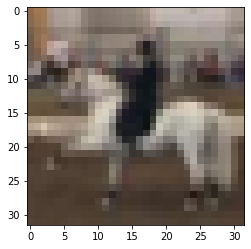

In [16]:
# check image
plt.imshow(test_image[0].cpu().permute(1,2,0))


In [17]:
# reshape test image and push into FC layer
tmp = torch.zeros((3,32+2*padding,32+2*padding))
tmp[:,padding:32+padding,padding:32+padding] = test_image[0]
tmp = tmp.flatten()
tmp = tmp.cuda()
fc = fc.cuda()
tmp2 = fc(tmp)

In [18]:
"""
 this here compares the sum and the difference of both vectors
  since the vector is very high dimensional it would be very unlikely that the sum is close
  but the computations wouldnt be the same
"""
print(torch.sum(tmp1))
print(torch.sum(tmp2))
print(torch.sum(torch.abs(tmp1.flatten()-tmp2)))

tensor(-2043.4451, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2043.4451, device='cuda:0', grad_fn=<SumBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<SumBackward0>)


In [19]:
%reload_ext tensorboard
%cd "/content/drive/My Drive/Colab Notebooks/Cuda Vision Lab/Assignment4"
!ls

/content/drive/My Drive/Colab Notebooks/Cuda Vision Lab/Assignment4
assignment4_final.ipynb  assignment4_V6.ipynb
Assignment4ResultsLog	 CUDA_Assignment_4.ipynb
assignment4_V0.ipynb	 cudaVisionlab_assignment_4_Akter,Schmidt.ipynb
assignment4_V3.ipynb	 data
assignment4_V4.ipynb	 lightning_logs
assignment4_V5.ipynb


In [20]:
%tensorboard --logdir lightning_logs

<IPython.core.display.Javascript object>

In [ ]:
!kill 12212